In [1]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import pylab
from bilby.core.prior import Uniform, Sine, Cosine, PowerLaw, Constraint
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import sigmasq
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import read as psd_read    

%matplotlib inline

In [2]:
prior=dict(dec=Cosine(name='dec'),
           ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
           theta_jn=Sine(name='theta_jn'))

In [3]:
def calculate_snr(param_args, ifos_obj, psd_analytical=False, ra=2.2, dec=-1.25, pol=2.1, t_gps=120):
    sample_rate=1024
    apx='IMRPhenomD'
    f_lower=10
    hp, hc=get_td_waveform(approximant=apx,
                            mass1=param_args['mass_1'],
                            mass2=param_args['mass_2'],
                            spin1z=param_args['spin_1z'],
                            spin1x=param_args['spin_1x'],
                            spin1y=param_args['spin_1y'],
                            spin2z=param_args['spin_2z'],
                            spin2x=param_args['spin_2x'],
                            spin2y=param_args['spin_2y'],
                            inclination=param_args['theta_jn'],
                            coa_phase=param_args['phase'],
                            distance=param_args['luminosity_distance'],
                            f_lower=f_lower,
                            delta_t=1.0/sample_rate)


    flow = 10.0
    delta_f = 1.0 / hp.duration 
    flen = int(sample_rate/delta_f)
    if psd_analytical:
        psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow) #optimize by calculating only once   
    else:
        read_data = np.genfromtxt('o3_h1.txt')
        psd_data = read_data[:, 1]
        psd_data = psd_data ** 2
        freq = read_data[:, 0]
        psd = psd_read.from_numpy_arrays(freq, psd_data,flen, delta_f, 20)
        psd.data[np.argwhere(psd.data == 0)] = 1
    gw = {'hp': hp, 'hc':hc, 'psd': psd}
    
    for det in ifos_obj:
        fp, fc=det.antenna_pattern(ra, dec, pol, t_gps)
    
        s= fp * gw['hp'] + fc * gw['hc']
        snr = sigmasq(s,psd=gw['psd'], low_frequency_cutoff=10)
        if 'snr_sq' in gw:  
            gw['snr_sq'] += snr
        else:
            gw['snr_sq'] = snr
            
    return np.sqrt(gw['snr_sq'])

def distance_snr_drops(param_args, m1_distr, m2_distr, ifos_obj, snr_thres=8, step=50, psd_analytical=False):
    max_distance = []
    for m1, m2 in zip(m1_distr, m2_distr):
        distance = 1
        while True:
            param_args['mass_1']=m1
            param_args['mass_2']=m2
            param_args['luminosity_distance']=distance
            snr = calculate_snr(param_args, ifos_obj, psd_analytical=psd_analytical)
            distance += step
    
            if snr < snr_thres:
                max_distance.append(distance)
                break
    return max_distance

In [4]:
#set up ifos objects
ifos=['H1', 'L1', 'V1']
ifos_det = []

for ifo in ifos:
    ifos_det.append(Detector(ifo))

In [5]:
param_args = dict(mass_1=35,
                  mass_2=35,
                  spin_1z=0,
                  spin_1x=0,
                  spin_1y=0,
                  spin_2z=0,
                  spin_2x=0,
                  spin_2y=0,
                  phase=0)

In [7]:
#create samples for ra, dec and inclination
n=100
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)

In [37]:
param_args['luminosity_distance']=1
max_distance=list() 
for i in range(n):
    param_args['luminosity_distance']=1
    while True:
        param_args['theta_jn']=theta_jn_lst[i] 
        snr=calculate_snr(param_args, ifos_det, ra=ra_lst[i], dec=dec_lst[i])        
        
        if snr < 8:
            max_distance.append(param_args['luminosity_distance'])
            break
        param_args['luminosity_distance']+=50

Text(0, 0.5, 'Distance (Mpc)')

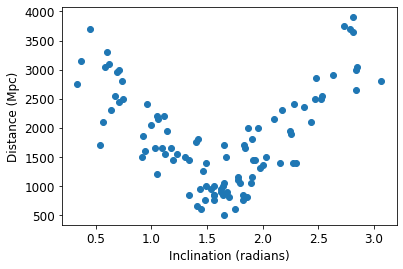

In [39]:
pylab.scatter(theta_jn_lst, max_distance)
pylab.xlabel("Inclination (radians)")
pylab.ylabel("Distance (Mpc)")

In [ ]:
#optimized minimum distance function
param_args['luminosity_distance']=1
max_distance_opt=list() 
for i in range(n):
    print(i)
    param_args['luminosity_distance']=1
    while True:
        param_args['theta_jn']=theta_jn_lst[i] 
        snr=calculate_snr(param_args, ifos_det, ra=ra_lst[i], dec=dec_lst[i])        
        if snr < 8:
            max_distance_opt.append(param_args['luminosity_distance'])
            break
        if snr >= 16:
            print(f"SNR = {snr}, distance = {param_args['luminosity_distance']}")
            param_args['luminosity_distance']= param_args['luminosity_distance'] * (snr/8)
        else:
            param_args['luminosity_distance']+=50
        print(f"new distance={param_args['luminosity_distance']}")

Text(0, 0.5, 'Distance (Mpc)')

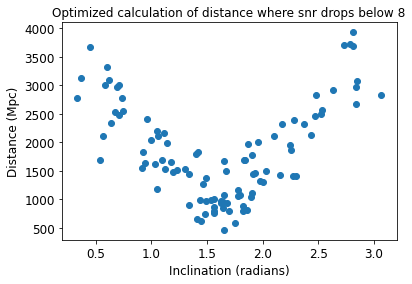

In [41]:
pylab.scatter(theta_jn_lst, max_distance_opt)
pylab.title("Optimized calculation of distance where snr drops below 8")
pylab.xlabel("Inclination (radians)")
pylab.ylabel("Distance (Mpc)")

Text(0.5, 0, 'Diference in distance')

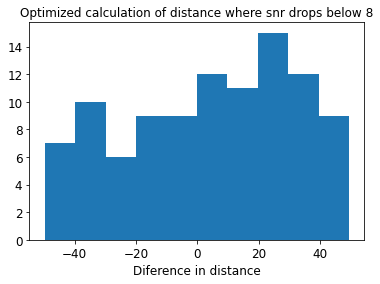

In [48]:
pylab.hist(np.array(max_distance_opt)-np.array(max_distance))
pylab.title("Optimized calculation of distance where snr drops below 8")
pylab.xlabel("Diference in distance")

Text(0, 0.5, 'dec')

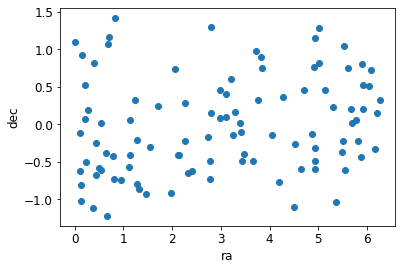

In [43]:
pylab.scatter(ra_lst, dec_lst)
pylab.xlabel("ra")
pylab.ylabel("dec")

Text(0, 0.5, 'distance (Mpc)')

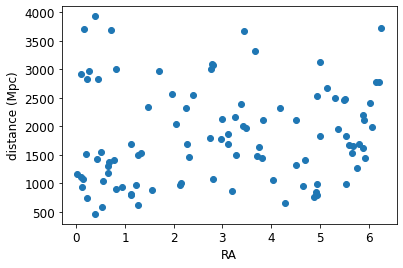

In [44]:
pylab.scatter(ra_lst, max_distance_opt)
pylab.xlabel("RA")
pylab.ylabel("distance (Mpc)")

Text(0, 0.5, 'distance (Mpc)')

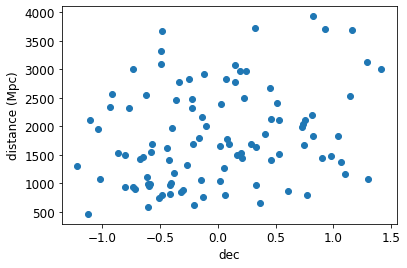

In [45]:
pylab.scatter(dec_lst, max_distance_opt)
pylab.xlabel("dec")
pylab.ylabel("distance (Mpc)")